----
### 04. Modeling

**Objective:**  to experiment with a range of machine learning models, starting with a simple Logistic Regression baseline  and move to a more powerful algorithms to improve predictive performance in identifying fraudulent transactions. Challenged by the severe class imbalance within the dataset.

---

In [1]:
from src.data_loader import load_data

raw_data = load_data("../data/creditcard.csv")

raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
from sklearn.model_selection import train_test_split

X = raw_data.iloc[:, :-1]
y = raw_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify= y, random_state=3479)

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845,), (56962, 30), (56962,))

-----
### 4.1 Baseline Logistic Regression Model

In [4]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from src.feature_engineering import FeatureEngineer
import pandas as pd

categorical_features = ["Time_segment"]

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    # keep all other columns (eg numeric features)
    remainder="passthrough"
)

# Final pipeline
pipeline_lr = Pipeline([
    ("feature_engineer", FeatureEngineer()),
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(class_weight="balanced", random_state=3479, max_iter=5000))
])

pipeline_lr.fit(X_train, y_train)

# Convert pipeline steps to a Pandas DataFrame
pipeline_df = pd.DataFrame(
    [(i+1, name, type(step).__name__) for i, (name, step) in enumerate(pipeline_lr.steps)],
    columns=['Step', 'Name', 'Type']
)

pipeline_df.style.hide(axis="index")
# Display without the DataFrame index

CPU times: total: 16.2 s
Wall time: 4.17 s


Step,Name,Type
1,feature_engineer,FeatureEngineer
2,preprocessor,ColumnTransformer
3,classifier,LogisticRegression


In [5]:
y_pred_lr = pipeline_lr.predict(X_test)

-----
#### Evaluation

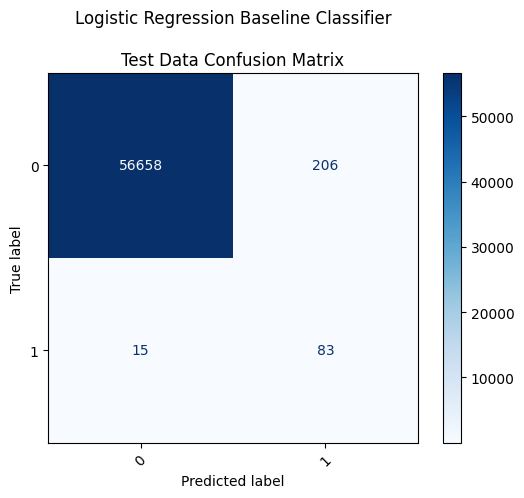

In [6]:
from src.model import evaluate_model

lr_metrics = evaluate_model(pipeline_lr, X_test, y_test, model_name="Logistic Regression Baseline Classifier", print_c_matrix=True)

In [7]:
lr_metrics

,precision,recall,f1-score,Balanced Accuracy,PR AUC,ROC AUC
0,1.000,0.996,0.998,0.922,0.719,0.978
1,0.287,0.847,0.429,0.922,0.719,0.978
macro avg,0.643,0.922,0.713,0.922,0.719,0.978
weighted avg,0.999,0.996,0.997,0.922,0.719,0.978



`Interim outcome:`
The Baseline Logistic regression achieved a PR-AUC of 0.71, which is strong starting point for this severe class-imbalance . However, the model shows poor precision of for the positive class (Class Fraud) of 0.29 --> indicating many false positives. This underscores the need for a more  powerful models.

`Considerations moving forward:`

- I will apply balanced class weight
- Consider the use of `Synthetic Minority Oversampling Technique (SMOTE)` use variants of the existing samples, to generate more samples for the minority class
- -----

### 4.2 CatBoost Classifier

CatBoost Classifier is a model based on gradient-boosted sequential decision trees (weak learners) where each tree corrects the previous errors. This model  has been selected to be the first advanced Classifier due to:

- Native handling of categorical data.
- Strength in handling minority classes through (`class_weights`, and `auto_class_weights = balanced`).
- Requires minimum fine-tuning.



In [8]:
%%time
# 1. Importing CatBoost model
from catboost import CatBoostClassifier

# 2. Build the pipeline
categorical_features = ['Time_segment']

# Final pipeline
catboost_model = Pipeline([
    ("feature_engineer", FeatureEngineer()),
    ("classifier", CatBoostClassifier(
        iterations=1000,
        # Number of boosted trees CatBoost will build.
        auto_class_weights="Balanced",
        # Automatically increases the importance of the minority class.
        # Handles severe class imbalance without manually computing weights.
        learning_rate=0.01,
        depth=6,
        # The depth of each decision tree.
        cat_features=categorical_features,
        eval_metric="PRAUC",
        # The metric CatBoost optimizes during training.
        verbose=50
        # Prints progress every 100 iterations to monitor training
    ))
])

# 3. Train/ fit the model
catboost_model.fit(X_train, y_train)

# Convert pipeline steps to a Pandas DataFrame
pipeline_df = pd.DataFrame(
    [(i+1, name, type(step).__name__) for i, (name, step) in enumerate(catboost_model.steps)],
    columns=['Step', 'Name', 'Type']
)

pipeline_df.style.hide(axis="index")
# Display without the DataFrame index

0:	learn: 0.9713467	total: 231ms	remaining: 3m 50s
50:	learn: 0.9964190	total: 4.05s	remaining: 1m 15s
100:	learn: 0.9978375	total: 7.98s	remaining: 1m 11s
150:	learn: 0.9985248	total: 11.8s	remaining: 1m 6s
200:	learn: 0.9989539	total: 15.6s	remaining: 1m 2s
250:	learn: 0.9992421	total: 19.4s	remaining: 58s
300:	learn: 0.9994188	total: 23.2s	remaining: 53.9s
350:	learn: 0.9995400	total: 26.9s	remaining: 49.8s
400:	learn: 0.9996557	total: 30.8s	remaining: 46s
450:	learn: 0.9997018	total: 34.7s	remaining: 42.3s
500:	learn: 0.9997339	total: 38.6s	remaining: 38.4s
550:	learn: 0.9997540	total: 42.2s	remaining: 34.4s
600:	learn: 0.9997767	total: 46s	remaining: 30.5s
650:	learn: 0.9997895	total: 49.9s	remaining: 26.7s
700:	learn: 0.9998099	total: 53.8s	remaining: 23s
750:	learn: 0.9998229	total: 57.7s	remaining: 19.1s
800:	learn: 0.9998423	total: 1m 1s	remaining: 15.3s
850:	learn: 0.9998519	total: 1m 5s	remaining: 11.4s
900:	learn: 0.9998594	total: 1m 9s	remaining: 7.62s
950:	learn: 0.999865

Step,Name,Type
1,feature_engineer,FeatureEngineer
2,classifier,CatBoostClassifier


#### Evaluation

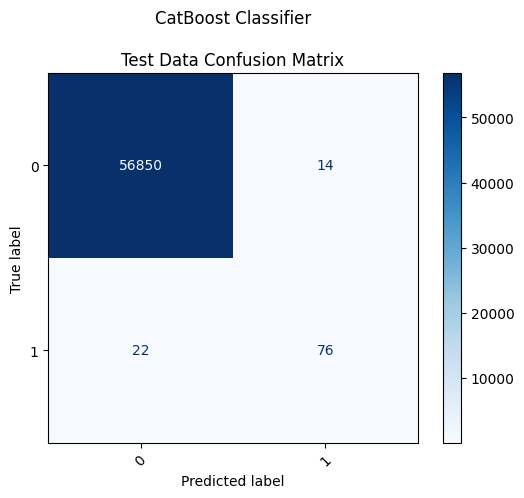

In [9]:
catboost_metrics = evaluate_model(catboost_model, X_test, y_test, model_name="CatBoost Classifier", print_c_matrix=True)

In [10]:
catboost_metrics

,precision,recall,f1-score,Balanced Accuracy,PR AUC,ROC AUC
0,1.000,1.000,1.000,0.888,0.808,0.973
1,0.844,0.776,0.809,0.888,0.808,0.973
macro avg,0.922,0.888,0.904,0.888,0.808,0.973
weighted avg,0.999,0.999,0.999,0.888,0.808,0.973


`Interim outcome:`
The `CatBoost(Gradient Boosted Tree)` model outperformed the baseline model (i.e. Logistic regression) achieving PR AUC of ~0.81 with higher precision for the positive class  (class fraud).